# S1W2D7 - 训练循环“八股文”与总结

**今日任务：**巩固与默写

今天的学习分为两部分：
1. **实战挑战**：“白板默写训练八股文
2. **理论补完**：深入理解`model.train()`和`model.eval()`的区别

## 核心挑战：”白板“默写挑战

尝试**从头到尾**、**仅凭记忆**写出一个完整的MNIST训练脚本

In [1]:
# Cell 1.5: 设置日志记录 (Logging)
# -------------------------------------------
import logging
import sys

# --- 配置 Logger ---
# 我们只在 logger 还没有被配置过的情况下进行配置
if not logging.getLogger().handlers:
    
    # 定义日志格式
    log_formatter = logging.Formatter(
        "%(asctime)s [%(levelname)s] - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    
    # 1. 设置文件处理器 (File Handler)，写入 'training.log'
    file_handler = logging.FileHandler("training.log")
    file_handler.setFormatter(log_formatter)
    
    # 2. 设置流处理器 (Stream Handler)，输出到控制台/Notebook
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setFormatter(log_formatter)
    
    # 获取根 logger 并添加处理器
    logger = logging.getLogger()
    logger.setLevel(logging.INFO) # 设置日志级别
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)

# 现在，你可以用 logger.info("...") 来代替 print("...")
logger = logging.getLogger()

logger.info("--- 日志系统配置完毕 ---")

2025-11-16 21:25:02 [INFO] - --- 日志系统配置完毕 ---


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(batch_size=64, root='../../data', num_workers=4):
    # 定义数组转换
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 下载并加载训练数据
    train_dataset = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers   # 在 WSL/Linux 上 4 是个好数字
    )
    
    test_dataset = datasets.MNIST(
        root=root,
        train=False, # <-- 关键区别
        download=True,
        transform=transform
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size * 2, # 验证时 batch 可以稍大
        shuffle=False, # 验证时不需要打乱
        num_workers=num_workers
    )
    logger.info(f"Training data loaded: {len(train_dataset)} samples.")
    return train_loader, test_loader

In [3]:
# 主脚本

import torch
import torch.nn as nn
import torch.nn.functional as F # 通常F被用于调用无参数的函数式API

class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 784) # -1 会自动计算为 BatchSize (B)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
from torch import optim
# 检查cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}") # <-- 使用 logger
model = MyMLP().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)


2025-11-16 21:25:08 [INFO] - Using device: cuda


In [9]:
# Cell 4: 训练与验证循环 (修改后)
# -------------------------------------------

logger.info(" ---- 开始训练 ---- ")

num_epochs = 5
# [修改] 同时获取两个加载器
train_loader, test_loader = get_data_loaders(batch_size=64, num_workers=4)

# --- [新增] ---
# 1. 定义一个变量来跟踪最高准确率
best_accuracy = 0.0
# 2. 定义模型保存路径
MODEL_SAVE_PATH = "best_model.pth"
# ----------------

for epoch in range(num_epochs):
    
    # --- 1. 训练阶段 ---
    model.train() # <--- 切换到训练模式 (启用 Dropout, BN 等)
    running_loss = 0.0
    
    for batch_idx, (data, labels) in enumerate(train_loader): # type: ignore
        
        data = data.to(device)
        labels = labels.to(device)
        
        # 核心 5 步
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            # [修改] 使用 logger
            logger.info(f"  [训练] Epoch [{epoch+1}/{num_epochs}], "
                        f"Step [{batch_idx+1}/{len(train_loader)}], " # type: ignore
                        f"Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader) # type: ignore

    # --- 2. [新增] 验证阶段 ---
    model.eval() # <--- 切换到评估模式 (关闭 Dropout, BN 等)
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # <--- 评估时不需要计算梯度，节省内存
        for data, labels in test_loader: # type: ignore
            data = data.to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels) # 计算验证损失
            val_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader) # type: ignore
    val_accuracy = 100 * correct / total

    # [修改] 使用 logger 打印 Epoch 总结
    logger.info(f"*** Epoch {epoch+1} 总结 ***")
    logger.info(f"  平均训练损失: {avg_train_loss:.4f}")
    logger.info(f"  平均验证损失: {avg_val_loss:.4f}")
    logger.info(f"  验证准确率: {val_accuracy:.2f} %")

    # --- [新增] 保存最佳模型 ---
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        logger.info(f"  模型已保存，新的最佳准确率: {MODEL_SAVE_PATH} %")
    logger.info("-" * 20)


logger.info("--- 训练完成 ---")
logger.info(f"最佳模型保存在: {MODEL_SAVE_PATH} (准确率: {best_accuracy:.2f}%)")

2025-11-16 21:30:27 [INFO] -  ---- 开始训练 ---- 
2025-11-16 21:30:27 [INFO] - Training data loaded: 60000 samples.
2025-11-16 21:30:28 [INFO] -   [训练] Epoch [1/5], Step [100/938], Loss: 0.1722
2025-11-16 21:30:29 [INFO] -   [训练] Epoch [1/5], Step [200/938], Loss: 0.2763
2025-11-16 21:30:29 [INFO] -   [训练] Epoch [1/5], Step [300/938], Loss: 0.6218
2025-11-16 21:30:30 [INFO] -   [训练] Epoch [1/5], Step [400/938], Loss: 0.2038
2025-11-16 21:30:31 [INFO] -   [训练] Epoch [1/5], Step [500/938], Loss: 0.2983
2025-11-16 21:30:31 [INFO] -   [训练] Epoch [1/5], Step [600/938], Loss: 0.1552
2025-11-16 21:30:32 [INFO] -   [训练] Epoch [1/5], Step [700/938], Loss: 0.1248
2025-11-16 21:30:33 [INFO] -   [训练] Epoch [1/5], Step [800/938], Loss: 0.1325
2025-11-16 21:30:33 [INFO] -   [训练] Epoch [1/5], Step [900/938], Loss: 0.0418
2025-11-16 21:30:34 [INFO] - *** Epoch 1 总结 ***
2025-11-16 21:30:34 [INFO] -   平均训练损失: 0.2131
2025-11-16 21:30:34 [INFO] -   平均验证损失: 0.2453
2025-11-16 21:30:34 [INFO] -   验证准确率: 93.24 %


--- 这张图片是: 2 ---


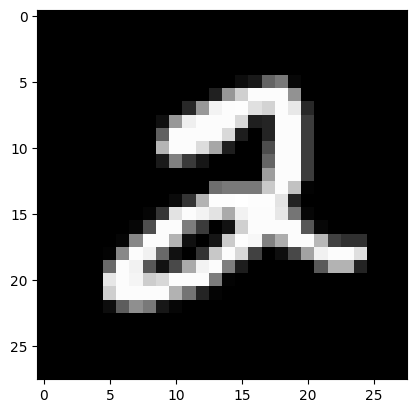

In [10]:
# 导入 matplotlib 用于绘图
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# ----------------------------------------------------
# 假设你的 get_data_loaders 和 transform 已经定义过了
# 我们重新加载一次数据，但这次不使用 Normalize，以便于显示
# ----------------------------------------------------

# 1. 定义一个只转换为 Tensor 的 transform
transform_for_viewing = torchvision.transforms.ToTensor()

# 2. 加载数据集
view_dataset = datasets.MNIST(
    root='../../data', 
    train=True, 
    download=False, # 假设已经下载过了
    transform=transform_for_viewing
)

# 3. 提取第 0 张图片
# image 是一个 [1, 28, 28] 的 Tensor
# label 是一个数字
image, label = view_dataset[5]

# 4. 使用 matplotlib 来显示它
print(f"--- 这张图片是: {label} ---")

# .squeeze() 用于去掉 [1, 28, 28] 中的 '1'，变为 [28, 28]
# .numpy() 是因为 matplotlib 需要 numpy 数组
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.show()

--- 预测批次中的第 5 张图 ---
模型预测: 1
真实标签: 1


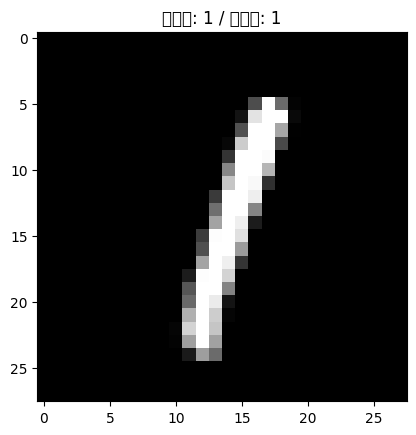

In [15]:
# Cell 2: (方案 A - 改进版 1) 预测批次中的第 N 张图

# -----------------------------------------------
# --- 你可以修改这里的数字 (0 到 63 之间) ---
IMAGE_INDEX_TO_PREDICT = 5 
# -----------------------------------------------

# 1. (不变) 从测试集里取一个批次的数据
try:
    images, labels = next(iter(test_loader)) # type: ignore
except NameError:
    # 如果 test_loader 不存在，就重新获取
    _, test_loader = get_data_loaders(batch_size=64, num_workers=4) # type: ignore
    images, labels = next(iter(test_loader)) # type: ignore

# 2. [修改] 取出这个批次中的第 N 张图片和标签
image_to_predict = images[IMAGE_INDEX_TO_PREDICT].unsqueeze(0).to(device)
true_label = labels[IMAGE_INDEX_TO_PREDICT]

# 3. (不变) 执行预测
with torch.no_grad():
    outputs = model(image_to_predict)

# 4. (不变) 解读输出
_, predicted = torch.max(outputs.data, 1)
predicted_digit = predicted.item()

# 5. (不变) 显示结果
print(f"--- 预测批次中的第 {IMAGE_INDEX_TO_PREDICT} 张图 ---")
print(f"模型预测: {predicted_digit}")
print(f"真实标签: {true_label}")

# [修改] 显示你选择的图片
plt.imshow(images[IMAGE_INDEX_TO_PREDICT].squeeze().numpy(), cmap='gray')
plt.title(f"真实值: {true_label} / 预测值: {predicted_digit}")
plt.show()